# Purpose
- trying to guess and understand what `params` argument in various [utilities in numpyro](http://num.pyro.ai/en/stable/utilities.html)
- looking over the docs it's not clear what params should be and the doc strings are either vague or terse IMO
- `params` is given a doc string on the lins of :
    * *dictionary of values for param sites of model/guide* from `Predictive`
    * *dictionary of current parameter values keyed by site name.* from `log_density`
    * *Dictionary of arrays keyed by names.* from `transform_fn`
    * *dictionary of unconstrained values keyed by site names.* from `constrain_fn`
    * *unconstrained parameters of model.* from `potential_energy`

1. **log_density**
    - signature: `log_density(model, model_args, model_kwargs, params)`
2. **potential_energy**
    - signature: `potential_energy(model, model_args, model_kwargs, params, enum=False)`
3. **log_likelihood**
    - signature: `log_likelihood(model, posterior_samples, *args, parallel=False, batch_ndims=1, **kwargs)`

The odd ball above is `log_likelihood` since there isn't a `params` argument, but I *feel* like `posterior_samples` might be a good starting place. Looking over the doc strings for `params` I am also thinking about the connection between *unconstrained* term to the doc string of `z` from [HMCState](http://num.pyro.ai/en/stable/mcmc.html?highlight=hmcstate#numpyro.infer.hmc.HMCState):

> `z` - Python collection representing values (unconstrained samples from the posterior) at latent sites.

In [1]:
import jax.numpy as jnp
import numpy as np
from jax import random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, log_likelihood
from numpyro.infer.util import log_density, potential_energy

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p jax,numpy,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

jax    : 0.2.19
numpy  : 1.20.3
numpyro: 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 97bdb55fe63d11c591b14b805e86549f87467073

Git branch: master



### Example of `params`
* a simple example is from [Stochastic Variational Inference (SVI)](http://num.pyro.ai/en/stable/svi.html?highlight=ELBO#stochastic-variational-inference-svi) doc example

In [5]:
def model(data):
    f = numpyro.sample("latent_fairness", dist.Beta(10, 10))
    with numpyro.plate("N", data.shape[0]):
        numpyro.sample("obs", dist.Bernoulli(f), obs=data)


def guide(data):
    alpha_q = numpyro.param("alpha_q", 15.0, constraint=constraints.positive)
    beta_q = numpyro.param(
        "beta_q",
        lambda rng_key: random.exponential(rng_key),
        constraint=constraints.positive,
    )
    numpyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))


data = jnp.concatenate([jnp.ones(6), jnp.zeros(4)])
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 2000, data)

100%|██████████| 2000/2000 [00:03<00:00, 640.96it/s, init loss: 68.4248, avg. loss [1901-2000]: 20.9142]


In [6]:
params = svi_result.params
params

{'alpha_q': DeviceArray(5.915417, dtype=float32),
 'beta_q': DeviceArray(0.93957573, dtype=float32)}

### A Simple Example - 8 Schools
* from [Getting Started with NumPyro](http://num.pyro.ai/en/stable/getting_started.html#getting-started-with-numpyro)

In [7]:
J = 8

y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])

sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [8]:
# Eight Schools example
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    with numpyro.plate("J", J):
        theta = numpyro.sample("theta", dist.Normal(mu, tau))
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

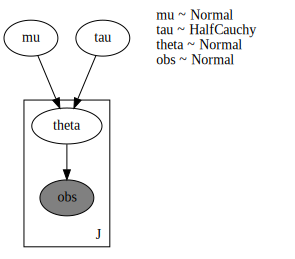

In [9]:
numpyro.render_model(eight_schools, model_args=(J, sigma, y), render_distributions=True)

In [10]:
nuts_kernel = NUTS(eight_schools)

In [11]:
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

In [12]:
rng_key = random.PRNGKey(0)

In [13]:
mcmc.run(
    rng_key,
    J,
    sigma,
    y=y,
    extra_fields=(
        "i",
        "z",
        "z_grad",
        "potential_energy",
        "energy",
        "r",
        "trajectory_length",
        "num_steps",
        "accept_prob",
        "mean_accept_prob",
        "diverging",
        "adapt_state",
        "rng_key",
    ),
)

sample: 100%|██████████| 1500/1500 [00:03<00:00, 385.34it/s, 31 steps of size 3.72e-02. acc. prob=0.99]


In [14]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.34      3.09      4.19     -0.63      9.17    147.86      1.01
       tau      3.40      2.87      2.68      0.23      7.25     71.79      1.00
  theta[0]      5.84      5.04      5.19     -2.38     13.28    240.45      1.01
  theta[1]      4.88      4.36      4.70     -1.05     12.77    284.49      1.00
  theta[2]      3.91      5.36      4.05     -3.95     12.20    289.84      1.00
  theta[3]      4.58      4.65      4.30     -1.96     12.95    248.48      1.00
  theta[4]      3.65      4.27      3.74     -3.17     10.23    210.01      1.00
  theta[5]      3.95      4.47      4.05     -3.43     10.77    247.01      1.00
  theta[6]      6.25      4.88      5.36     -1.52     13.57    167.16      1.00
  theta[7]      4.79      4.98      4.38     -2.87     11.75    288.12      1.01

Number of divergences: 1


In [15]:
mcmc.get_extra_fields().keys()

dict_keys(['trajectory_length', 'i', 'rng_key', 'diverging', 'accept_prob', 'adapt_state', 'mean_accept_prob', 'z_grad', 'num_steps', 'energy', 'potential_energy', 'r'])

In [16]:
pe = mcmc.get_extra_fields()["potential_energy"]

In [17]:
print("Expected log joint density: {:.2f}".format(np.mean(-pe)))

Expected log joint density: -52.88


In [18]:
mcmc.get_samples().keys()

dict_keys(['mu', 'tau', 'theta'])

In [19]:
mcmc.get_samples()["mu"].mean()

DeviceArray(4.335294, dtype=float32)

In [20]:
mcmc.get_samples()["tau"].mean()

DeviceArray(3.4035494, dtype=float32)

In [21]:
mcmc.get_samples()["theta"].mean(0)

DeviceArray([5.8382387, 4.882821 , 3.9094636, 4.5816617, 3.6524198,
             3.9543827, 6.246379 , 4.7896934], dtype=float32)

### **log_likelihood** 

signature: `log_likelihood(model, posterior_samples, *args, parallel=False, batch_ndims=1, **kwargs)`

* A good example of `log_likelihood` is from the [Example: Baseball Batting Average](http://num.pyro.ai/en/stable/examples/baseball.html#example-baseball-batting-average)

In [22]:
log_likelihood(
    eight_schools, mcmc.get_samples(), J, sigma, y=y,
)

{'obs': DeviceArray([[-4.756407 , -3.2456636, -3.8251836, ..., -3.3881338,
               -4.007017 , -3.8848321],
              [-4.7805824, -3.260985 , -3.832055 , ..., -3.390484 ,
               -4.022484 , -3.8712993],
              [-4.804057 , -3.2758784, -3.8072424, ..., -3.3769853,
               -4.069317 , -3.882395 ],
              ...,
              [-4.6730614, -3.322598 , -3.9107308, ..., -3.3942003,
               -3.4346957, -3.860128 ],
              [-4.588113 , -3.2291913, -3.8683748, ..., -3.4205554,
               -4.2612643, -3.8601947],
              [-4.930333 , -3.2294831, -4.070707 , ..., -3.486361 ,
               -4.5297904, -3.8479528]], dtype=float32)}

In [23]:
post_loglik = log_likelihood(eight_schools, mcmc.get_samples(), J, sigma, y=y,)["obs"]
exp_log_density = logsumexp(post_loglik, axis=0) - jnp.log(jnp.shape(post_loglik)[0])

In [24]:
exp_log_density, exp_log_density.sum()

(DeviceArray([-4.6737185, -3.347174 , -3.8256943, -3.4159744, -3.328764 ,
              -3.4226027, -3.9185274, -3.9200714], dtype=float32),
 DeviceArray(-29.852526, dtype=float32))

### **log_density** 

signature: `log_density(model, model_args, model_kwargs, params)`

In [25]:
{
    "mu": mcmc.get_samples()["mu"].mean(),
    "tau": mcmc.get_samples()["tau"].mean(),
    "theta": mcmc.get_samples()["theta"].mean(0),
}

{'mu': DeviceArray(4.335294, dtype=float32),
 'tau': DeviceArray(3.4035494, dtype=float32),
 'theta': DeviceArray([5.8382387, 4.882821 , 3.9094636, 4.5816617, 3.6524198,
              3.9543827, 6.246379 , 4.7896934], dtype=float32)}

In [26]:
log_joint_density, model_trace = log_density(
    eight_schools,
    (J, sigma),
    dict(y=y),
    {
        "mu": mcmc.get_samples()["mu"].mean(),
        "tau": mcmc.get_samples()["tau"].mean(),
        "theta": mcmc.get_samples()["theta"].mean(0),
    },
)

In [27]:
log_joint_density

DeviceArray(-52.32869, dtype=float32)

In [28]:
for values in mcmc.get_samples().values():
    print(values.shape)

(1000,)
(1000,)
(1000, 8)


* seems like if you pass `mcmc.get_samples()` always results in a `ValueError: Incompatible shapes for broadcasting`

```python
log_joint_density, model_trace = log_density(
    eight_schools,
    (J, sigma),
    dict(y=y),
    mcmc.get_samples(),
)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-26-1d0d15e69ba2> in <module>
----> 1 log_joint_density, model_trace = log_density(
      2     eight_schools,
      3     (J, sigma),
      4     dict(y=y),mcmc.get_samples(),
      5 )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in log_density(model, model_args, model_kwargs, params)
     51     """
     52     model = substitute(model, data=params)
---> 53     model_trace = trace(model).get_trace(*model_args, **model_kwargs)
     54     log_joint = jnp.zeros(())
     55     for site in model_trace.values():

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/handlers.py in get_trace(self, *args, **kwargs)
    163         :return: `OrderedDict` containing the execution trace.
    164         """
--> 165         self(*args, **kwargs)
    166         return self.trace
    167 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

<ipython-input-3-d4380d296306> in eight_schools(J, sigma, y)
      4     tau = numpyro.sample("tau", dist.HalfCauchy(5))
      5     with numpyro.plate("J", J):
----> 6         theta = numpyro.sample("theta", dist.Normal(mu, tau))
      7         numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in sample(name, fn, obs, rng_key, sample_shape, infer, obs_mask)
    157 
    158     # ...and use apply_stack to send it to the Messengers
--> 159     msg = apply_stack(initial_msg)
    160     return msg["value"]
    161 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in apply_stack(msg)
     22     pointer = 0
     23     for pointer, handler in enumerate(reversed(_PYRO_STACK)):
---> 24         handler.process_message(msg)
     25         # When a Messenger sets the "stop" field of a message,
     26         # it prevents any Messengers above it on the stack from being applied.

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in process_message(self, msg)
    478             overlap_idx = max(len(expected_shape) - len(dist_batch_shape), 0)
    479             trailing_shape = expected_shape[overlap_idx:]
--> 480             broadcast_shape = lax.broadcast_shapes(
    481                 trailing_shape, tuple(dist_batch_shape)
    482             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/jax/_src/util.py in wrapper(*args, **kwargs)
    184         return f(*args, **kwargs)
    185       else:
--> 186         return cached(config._trace_context(), *args, **kwargs)
    187 
    188     wrapper.cache_clear = cached.cache_clear

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/jax/_src/util.py in cached(_, *args, **kwargs)
    177     @functools.lru_cache(max_size)
    178     def cached(_, *args, **kwargs):
--> 179       return f(*args, **kwargs)
    180 
    181     @functools.wraps(f)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/jax/_src/lax/lax.py in broadcast_shapes(*shapes)
     90   result_shape = _try_broadcast_shapes(shapes)
     91   if result_shape is None:
---> 92     raise ValueError("Incompatible shapes for broadcasting: {}"
     93                      .format(tuple(map(tuple, shapes))))
     94   return result_shape

ValueError: Incompatible shapes for broadcasting: ((8,), (1000,))
```

### **potential_energy** 

signature: `potential_energy(model, model_args, model_kwargs, params, enum=False)`

In [29]:
pe_given_unconstrained_params = potential_energy(
    eight_schools,
    (J, sigma),
    dict(y=y),
    {
        "mu": mcmc.get_samples()["mu"].mean(),
        "tau": mcmc.get_samples()["tau"].mean(),
        "theta": mcmc.get_samples()["theta"].mean(0),
    },
)

In [30]:
pe_given_unconstrained_params

DeviceArray(69.27994, dtype=float32)

```python
pe_given_unconstrained_params = potential_energy(
    eight_schools,
    (J, sigma),
    dict(y=y),
    mcmc.get_samples(),
)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-31-2604c02b276c> in <module>
----> 1 pe_given_unconstrained_params = potential_energy(
      2     eight_schools,
      3     (J, sigma),
      4     dict(y=y),
      5     mcmc.get_samples(),

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in potential_energy(model, model_args, model_kwargs, params, enum)
    225     )
    226     # no param is needed for log_density computation because we already substitute
--> 227     log_joint, model_trace = log_density_(
    228         substituted_model, model_args, model_kwargs, {}
    229     )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/util.py in log_density(model, model_args, model_kwargs, params)
     51     """
     52     model = substitute(model, data=params)
---> 53     model_trace = trace(model).get_trace(*model_args, **model_kwargs)
     54     log_joint = jnp.zeros(())
     55     for site in model_trace.values():

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/handlers.py in get_trace(self, *args, **kwargs)
    163         :return: `OrderedDict` containing the execution trace.
    164         """
--> 165         self(*args, **kwargs)
    166         return self.trace
    167 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in __call__(self, *args, **kwargs)
     85             return self
     86         with self:
---> 87             return self.fn(*args, **kwargs)
     88 
     89 

<ipython-input-3-d4380d296306> in eight_schools(J, sigma, y)
      4     tau = numpyro.sample("tau", dist.HalfCauchy(5))
      5     with numpyro.plate("J", J):
----> 6         theta = numpyro.sample("theta", dist.Normal(mu, tau))
      7         numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in sample(name, fn, obs, rng_key, sample_shape, infer, obs_mask)
    157 
    158     # ...and use apply_stack to send it to the Messengers
--> 159     msg = apply_stack(initial_msg)
    160     return msg["value"]
    161 

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in apply_stack(msg)
     22     pointer = 0
     23     for pointer, handler in enumerate(reversed(_PYRO_STACK)):
---> 24         handler.process_message(msg)
     25         # When a Messenger sets the "stop" field of a message,
     26         # it prevents any Messengers above it on the stack from being applied.

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/primitives.py in process_message(self, msg)
    478             overlap_idx = max(len(expected_shape) - len(dist_batch_shape), 0)
    479             trailing_shape = expected_shape[overlap_idx:]
--> 480             broadcast_shape = lax.broadcast_shapes(
    481                 trailing_shape, tuple(dist_batch_shape)
    482             )

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/jax/_src/util.py in wrapper(*args, **kwargs)
    184         return f(*args, **kwargs)
    185       else:
--> 186         return cached(config._trace_context(), *args, **kwargs)
    187 
    188     wrapper.cache_clear = cached.cache_clear

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/jax/_src/util.py in cached(_, *args, **kwargs)
    177     @functools.lru_cache(max_size)
    178     def cached(_, *args, **kwargs):
--> 179       return f(*args, **kwargs)
    180 
    181     @functools.wraps(f)

~/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/jax/_src/lax/lax.py in broadcast_shapes(*shapes)
     90   result_shape = _try_broadcast_shapes(shapes)
     91   if result_shape is None:
---> 92     raise ValueError("Incompatible shapes for broadcasting: {}"
     93                      .format(tuple(map(tuple, shapes))))
     94   return result_shape

ValueError: Incompatible shapes for broadcasting: ((8,), (1000,))
```